In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
moons = pd.DataFrame( np.load("moon-all-input.npy") )
moons.columns = ["x1", "x2"]
moons

,x1,x2
0,1.538699,0.188744
1,0.394699,0.323724
2,-0.919147,1.311882
3,1.053964,-0.700408
4,1.040678,-0.437339
...,...,...
495,1.163768,-0.710319
496,0.477238,-0.681340
497,-0.246390,0.709156
498,0.897480,0.382935


In [184]:
moons["category"] = pd.DataFrame(np.load("moon-all-output.npy"))

In [185]:
def get_color(row: pd.DataFrame):
    if row["category"] == 0:
        return "blue"
    else:
        return "red"


moons["color"] = moons.apply(lambda row: get_color(row), axis="columns")
moons

,x1,x2,category,color
0,1.538699,0.188744,1,red
1,0.394699,0.323724,0,blue
2,-0.919147,1.311882,0,blue
3,1.053964,-0.700408,1,red
4,1.040678,-0.437339,1,red
...,...,...,...,...
495,1.163768,-0.710319,1,red
496,0.477238,-0.681340,1,red
497,-0.246390,0.709156,0,blue
498,0.897480,0.382935,0,blue


<Axes: xlabel='x1', ylabel='x2'>

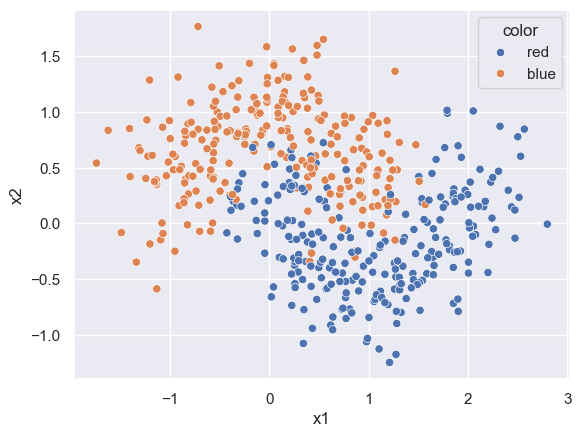

In [186]:
sns.set_theme()
sns.color_palette("Set2")
sns.scatterplot(data = moons, x="x1", y="x2", hue = "color")


In [187]:
moon_train, moon_test = moons.iloc[:375], moons.iloc[375:]
moon_train

,x1,x2,category,color
0,1.538699,0.188744,1,red
1,0.394699,0.323724,0,blue
2,-0.919147,1.311882,0,blue
3,1.053964,-0.700408,1,red
4,1.040678,-0.437339,1,red
...,...,...,...,...
370,0.435785,-0.186108,1,red
371,-0.565615,0.563578,0,blue
372,-1.205374,1.285517,0,blue
373,0.515727,-0.347822,1,red


In [188]:
moon_test

,x1,x2,category,color
375,0.501693,0.217172,1,red
376,0.227405,0.589937,1,red
377,0.268167,0.431114,1,red
378,1.312708,-0.595236,1,red
379,0.418356,-0.382677,1,red
...,...,...,...,...
495,1.163768,-0.710319,1,red
496,0.477238,-0.681340,1,red
497,-0.246390,0.709156,0,blue
498,0.897480,0.382935,0,blue


In [189]:

X_train = moon_train.iloc[:, :2].copy()
y_train = moon_train.iloc[:, 2].copy()

X_test = moon_test.iloc[:, :2].copy()
y_test = moon_test.iloc[:, 2].copy()


The data is largely balanced with the ratio being 0.344 instead of 0.333

In [190]:
moon_train["category"].sum(), moon_test["category"].sum()

(186, 64)

AdaBoost

In [191]:
from sklearn.tree import DecisionTreeClassifier

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)


class Classifier():
    classifier = None
    sample_weights = None
    error_weight = None
    classifier_weight = None
    learning_weight = 1
    X = None
    y = None
    y_pred = None

    def __init__(self, X, y, sample_weights, learning_rate=1):
        self.sample_weights = sample_weights
        self.learning_weight = learning_rate
        self.classifier = DecisionTreeClassifier(max_depth=1, random_state=42)
        self.X = X
        self.y = y

        self.classifier.fit(
            X, y, sample_weight=np.array(sample_weights).ravel())

    def calc_error(self):
        self.y_pred = self.classifier.predict(self.X)
        misclassified = self.sample_weights[self.y_pred != self.y]

        self.error_weight = misclassified.sum() / self.sample_weights.sum()

        return self.error_weight

    def calc_classifier_weight(self):
        self.calc_error()
        self.classifier_weight = (
            self.learning_weight * np.log((1-self.error_weight) / self.error_weight)).item()

        return self.classifier_weight

    def get_classifier_weight(self):
        return self.classifier_weight

    def get_new_sample_weights(self):
        self.calc_classifier_weight()

        current_weights = np.array(self.sample_weights)
        new_weights = np.empty(len(self.y_pred))
        pos_factor = np.exp(self.classifier_weight)
        neg_factor = np.exp(-self.classifier_weight)

        for i in range(len(self.y_pred)):
            if self.y_pred[i] != self.y[i]:
                new_weights[i] = current_weights[i] * pos_factor
            else:
                new_weights[i] = current_weights[i] * neg_factor

        # Normalizing the weights
        new_weights = new_weights / np.sum(new_weights)
        return new_weights

    def predict(self, X):
        return self.classifier.predict(X)


In [192]:
class AdaBoost():

    n_estimators = None
    classifiers = None
    X = None
    y = None
    learning_rate = 1

    def __init__(self, X, y, n_estimators=1, learning_rate=1):
        self.n_estimators = n_estimators
        self.classifiers = [None] * n_estimators
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.weights = None

    def fit(self):
        # Initializes the weights for all samples to 1/N, where N is the number of data points
        init_sample_weights = np.array(len(self.X) * [1/len(self.X)])
        self.classifiers[0] = Classifier(self.X, self.y, init_sample_weights)
        self.classifiers[0].calc_classifier_weight()

        for i in range(1, self.n_estimators):
            self.classifiers[i] = Classifier(
                self.X, self.y, self.classifiers[i-1].get_new_sample_weights())

        self.classifiers[-1].calc_classifier_weight()
        
        self.weights = np.array([clf.classifier_weight for clf in self.classifiers])

    def predict_sample(self, X, start, stop):
        voting_clfs = self.classifiers[start:stop]
        weight = self.weights[start:stop]
        # Calculate classifier weights for all classifiers at once
        # weights = np.array([clf.classifier_weight for clf in voting_clfs])

        # Predictions for all classifiers at once
        predictions = np.array([clf.predict(X) for clf in voting_clfs])

        # Count votes for class 1 and class 0
        vote_1 = np.sum(weight * (predictions == 1))
        vote_0 = np.sum(weight * (predictions == 0))

        if vote_1 > vote_0:
            return 1
        else:
            return 0

    def predict(self, X, clf_start=0, clf_stop=3000):
        

        stop = self.n_estimators

        if clf_stop < stop:
            stop = clf_stop

        predictions = np.empty(len(X), dtype=np.int8)

        for i in range(len(X)):
            predictions[i] = self.predict_sample(X.iloc[[i]], clf_start, stop)

        return predictions


In [193]:
ada = AdaBoost(X_train, y_train, n_estimators= 3000)

ada.fit()
print("Done fitting")

Done fitting


In [194]:
y_true = np.array(y_test)
y_true

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [195]:
from sklearn.metrics import accuracy_score
import time
def get_accuracy(X_test, y_true, ada: AdaBoost, stop = 3000):
    scores = np.empty(stop)
    
    for i in range(stop):
        # print(i)
        start_time = time.time()
        scores[i] = accuracy_score(y_true, ada.predict(X_test, clf_start = 0, clf_stop = i))
        score_df = pd.DataFrame(scores)
        score_df.to_csv("scores.csv")
        end_time = time.time()
        print(f"Ensemble {i}: {scores[i]}, Elapsed Time: {end_time - start_time:0.2f}")
        
    return scores

scores = get_accuracy(X_test, y_true, ada, 100)

Ensemble 0: 0.488, Elapsed Time: 0.01
Ensemble 1: 0.824, Elapsed Time: 0.07
Ensemble 2: 0.632, Elapsed Time: 0.13
Ensemble 3: 0.896, Elapsed Time: 0.18
Ensemble 4: 0.752, Elapsed Time: 0.24
Ensemble 5: 0.888, Elapsed Time: 0.29
Ensemble 6: 0.752, Elapsed Time: 0.35
Ensemble 7: 0.888, Elapsed Time: 0.46
Ensemble 8: 0.752, Elapsed Time: 0.46
Ensemble 9: 0.888, Elapsed Time: 0.51
Ensemble 10: 0.856, Elapsed Time: 0.56
Ensemble 11: 0.888, Elapsed Time: 0.63
Ensemble 12: 0.752, Elapsed Time: 0.67
Ensemble 13: 0.888, Elapsed Time: 0.73
Ensemble 14: 0.896, Elapsed Time: 0.78
Ensemble 15: 0.888, Elapsed Time: 0.84
Ensemble 16: 0.752, Elapsed Time: 0.89
Ensemble 17: 0.888, Elapsed Time: 0.94
Ensemble 18: 0.888, Elapsed Time: 1.00
Ensemble 19: 0.888, Elapsed Time: 1.08
Ensemble 20: 0.784, Elapsed Time: 1.11
Ensemble 21: 0.888, Elapsed Time: 1.17
Ensemble 22: 0.752, Elapsed Time: 1.22
Ensemble 23: 0.888, Elapsed Time: 1.27
Ensemble 24: 0.752, Elapsed Time: 1.35
Ensemble 25: 0.888, Elapsed Time: 1